## Visualization of CNN: Grad-CAM


Authors: GOMEZ, Diego, REGUEIRO ESPIÑO Ramón Daniel, SALAZAR, Israfel

email: {diego.gomez, ramon.regueiro_espino, israfel.salazar} @ens-paris-saclay.fr


* **Objective**: Convolutional Neural Networks are widely used on computer vision. It is powerful for processing grid-like data. However we hardly know how and why it works, due to the lack of decomposability into individually intuitive components. In this assignment, we use Grad-CAM, which highlights the regions of the input image that were important for the neural network prediction.


* NB: if `PIL` is not installed, try `conda install pillow`.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import pickle
import urllib.request

import numpy as np
from PIL import Image
from typing import List

%matplotlib inline

### Download the Model
We provide you a pretrained model `ResNet-34` for `ImageNet` classification dataset.
* **ImageNet**: A large dataset of photographs with 1 000 classes.
* **ResNet-34**: A deep architecture for image classification.

In [2]:
resnet34 = models.resnet34(pretrained=True)
resnet34.eval() # set the model to evaluation mode

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

![ResNet34](https://miro.medium.com/max/1050/1*Y-u7dH4WC-dXyn9jOG4w0w.png)


Input image must be of size (3x224x224). 

First convolution layer with maxpool. 
Then 4 ResNet blocks. 

Output of the last ResNet block is of size (512x7x7). 

Average pooling is applied to this layer to have a 1D array of 512 features fed to a linear layer that outputs 1000 values (one for each class). No softmax is present in this case. We have already the raw class score!

In [3]:
classes = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

##classes is a dictionary with the name of each class 
print(classes)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

### Input Images
We provide you 20 images from ImageNet (download link on the webpage of the course or download directly using the following command line,).<br>
In order to use the pretrained model resnet34, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(224, 224)`.

In [4]:
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

In [5]:
# The images should be in a *sub*-folder of "data/" (ex: data/TP2_images/images.jpg) and *not* directly in "data/"!
# otherwise the function won't find them

import os
os.mkdir("data")
os.mkdir("data/TP2_images")
!cd data/TP2_images && wget "https://www.lri.fr/~gcharpia/deeppractice/2023/TP2/TP2_images.zip" && unzip TP2_images.zip
dir_path = "data/" 
dataset = preprocess_image(dir_path)

--2023-02-10 11:10:50--  https://www.lri.fr/~gcharpia/deeppractice/2023/TP2/TP2_images.zip
Resolving www.lri.fr (www.lri.fr)... 129.175.15.11
Connecting to www.lri.fr (www.lri.fr)|129.175.15.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1477062 (1.4M) [application/zip]
Saving to: ‘TP2_images.zip’

TP2_images.zip      100%[===================>]   1.41M  1.67MB/s    in 0.8s    

2023-02-10 11:10:52 (1.67 MB/s) - ‘TP2_images.zip’ saved [1477062/1477062]

Archive:  TP2_images.zip
   creating: .ipynb_checkpoints/
  inflating: 155881293_721e90b57d.jpg  
  inflating: 158850087_3251644046.jpg  
  inflating: 1624593475_146bf1f7ff.jpg  
  inflating: 181748579_01a4611736.jpg  
  inflating: 2068921624_ef0986de13.jpg  
  inflating: 2637374064_fab14ec0b8.jpg  
  inflating: 2749465889_8e62023674.jpg  
  inflating: 2936812850_23bf0d1cfd.jpg  
  inflating: 3532471222_a6d7e3780e.jpg  
  inflating: 3633913271_ee789a3bc4.jpg  
  inflating: 3633949157_f577605ea9.jpg  
  infla

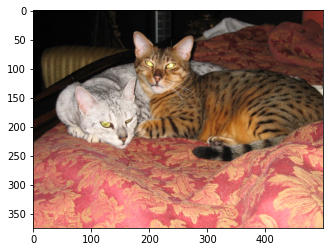

In [6]:
# show the orignal image 
index = 5
input_image = Image.open(dataset.imgs[index][0]).convert('RGB')
plt.imshow(input_image)

### Grad-CAM 
* **Overview:** Given an image, and a category (‘tiger cat’) as input, we forward-propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (tiger cat), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


* **To Do**: Define your own function Grad_CAM to achieve the visualization of the given images. For each image, choose the top-3 possible labels as the desired classes. Compare the heatmaps of the three classes, and conclude. 


* **To be submitted within 2 weeks**: this notebook, **cleaned** (i.e. without results, for file size reasons: `menu > kernel > restart and clean`), in a state ready to be executed (if one just presses 'Enter' till the end, one should obtain all the results for all images) with a few comments at the end. No additional report, just the notebook!


* **Hints**: 
 + We need to record the output and grad_output of the feature maps to achieve Grad-CAM. In pytorch, the function `Hook` is defined for this purpose. Read the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully. 
 + The pretrained model resnet34 doesn't have an activation function after its last layer, the output is indeed the `raw class scores`, you can use them directly. 
 + The size of feature maps is 7x7, so your heatmap will have the same size. You need to project the heatmap to the resized image (224x224, not the original one, before the normalization) to have a better observation. The function [`torch.nn.functional.interpolate`](https://pytorch.org/docs/stable/nn.functional.html?highlight=interpolate#torch.nn.functional.interpolate) may help.  
 + Here is the link of the paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

Class: ‘pug, pug-dog’ | Class: ‘tabby, tabby cat’
- | - 
![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/dog.jpg)| ![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/cat.jpg)

In [7]:
class GradCAM(nn.Module):
    """
    GradCAM Class
    This class implements the Grad-CAM algorithm for visual explanation of deep networks.
    
    Based on Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization.
    
    Attributes:
        base_model (nn.Module): The base model to be explained
        scores (Tensor): The activation scores from the output of the base model
        grads (Tensor): The gradients of the scores with respect to the input   
    """
    
    def __init__(self,
                model: nn.Module,
                ):
        """
        Initialization function for GradCAM class.
        Args:
            model: The base model to be explained.
            
        """
        super(GradCAM,self).__init__()
        self.base_model = model
        self.scores = None
        self.grads = None

        def forward_hook(model, input, output):
          self.scores = output[0]
        def backward_hook(model, input, output):
          self.grads = output[0][0]

        feat_map = self.base_model.layer4
        feat_map.register_forward_hook(forward_hook)
        feat_map.register_backward_hook(backward_hook)


    def forward(self, x, topk=3):
        out = self.base_model(x)
        num_features = self.scores.size()[0]
        values, indices = torch.topk(out, topk)

        # Compute 7x7 heatmaps
        heatmaps = torch.zeros(topk,7,7)
        self.base_model.layer4.zero_grad()
        self.base_model.fc.zero_grad()
        for i,c in enumerate(indices[0]):
            self.base_model.zero_grad()
            out[0,c].backward(retain_graph=True)

            # feature importance
            feature_importance = self.grads.mean(dim=[1,2])
            
            # pixel importance
            for f in range(num_features):
                heatmaps[i] += feature_importance[f] * self.scores[f]
            heatmaps[i] = F.relu(heatmaps[i])
        
        # Upsample to 224x224
        large_heatmaps = F.interpolate(heatmaps.expand((1,topk,7,7)), (224,224), mode='bilinear')
        return large_heatmaps[0].data, values.data.numpy()[0], indices.data.numpy()[0]

In [8]:
def visualize_results(model: torch.nn.Module,
                      indices: List[int], 
                      tfrm: callable,
                      topk:int=3):
    """
    This function visualizes the results of the model.

    Parameters:
    model: The model to be evaluated.
    indices: A list of indices to be evaluated from the dataset.
    tfrm: A callable transformation to be applied to the image.
    topk (optional): The number of top results to display, defaults to 3.

    Returns:
    None

    Example:
    >>> visualize_results(model, [0, 1, 2], tfrm, topk=3)
    """
    n = len(indices)
    figure = plt.figure(figsize=(topk*6, n*6))
    for i in range(n):
        heat_map, score_value, class_indices = model(dataset[indices[i]][0].unsqueeze(0))
        image = tfrm(Image.open(dataset.imgs[indices[i]][0]).convert('RGB'))
        for k in range(topk):
            plt.subplot(n+1, topk, (k+1)+i*topk)
            plt.imshow(image)
            plt.imshow(heat_map[k], alpha=0.5, cmap='jet')
            plt.title(f"Prediction: TOP-{k} - Image: {i} \n Label {classes[class_indices[k]]} \n Score {np.round(float(score_value[k]), 3)}")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


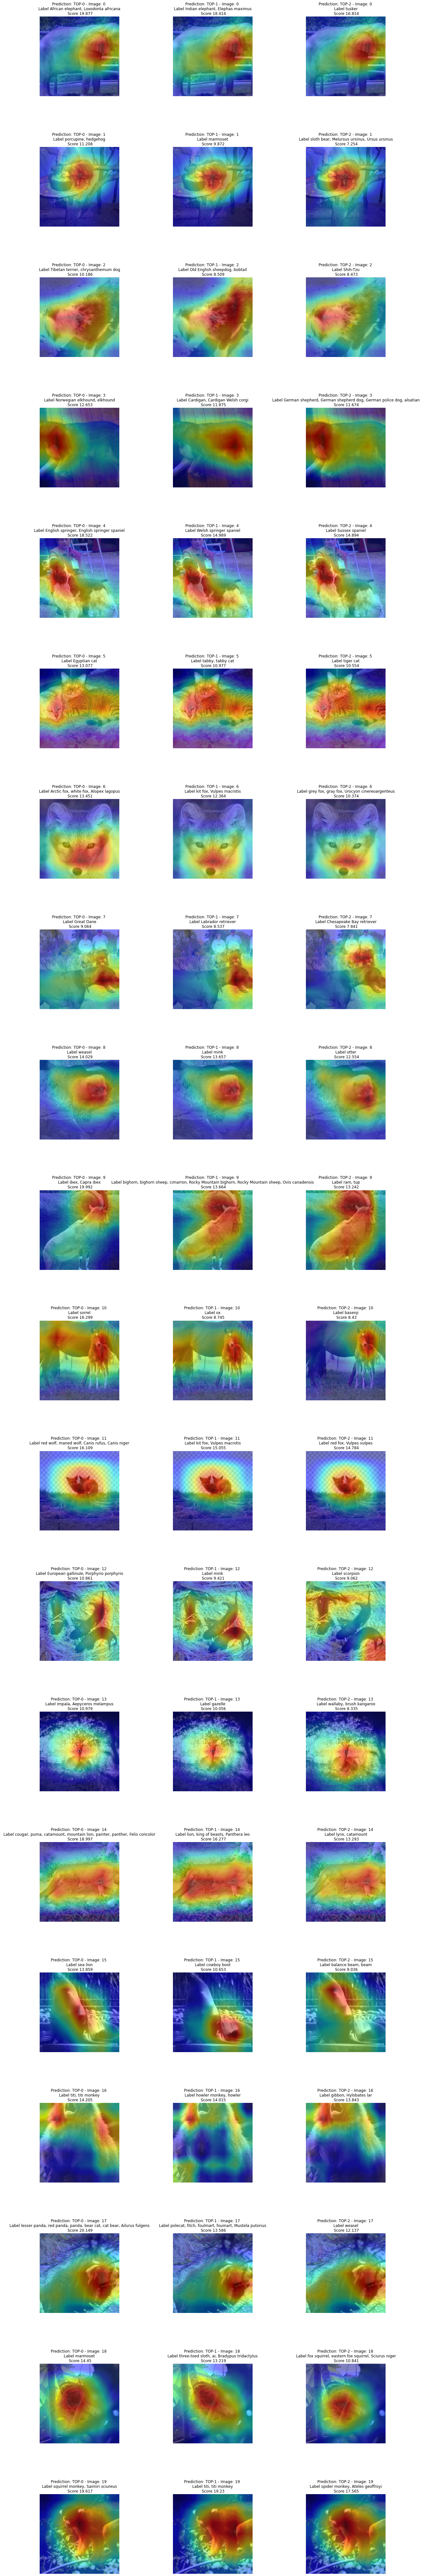

In [9]:
model = GradCAM(resnet34)

viz = transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224)])

visualize_results(model=model,
                  indices=range(20),
                  tfrm=viz)

**Discussion:**


In the figure above we can see the results of our GradCAM model for all the images in the given dataset. First, let's note that in general the model focuses on the central object of the image rather than the background. We can also see that in general the main object in the image is correctly classified in the TOP-1 result. In addition, we also see that the TOP-2 and TOP-3 classifications are generally close to the correct label, for instance, when classifying a dog it will change depending on the breed. We can also see that the scores between the TOP-3 classifications are similar. This is to expect given that the labels correspond to similar objects.




On the other hand, we can see that sometimes the model focuses on the wrong side of the image or takes a scope too large or too small that produces a misclassification. For instance, looking at the image of the sea lion (image 15), in the TOP-2 prediction we see that the model focussed on a small portion of the image and returns a totally different label. However we also see a significant drop on the confidence of the prediction compared to the other images. The opposite case happens with the deer (image 13) in which taking a larger area makes the model misclassify the deer for a wallaby in the TOP-3.


Another interesting result is image 7, the figure shows two dogs with people in the background. The model correctly changes the label when it focuses on the two different dogs. We can see that the people are not detected as part of the TOP-3 results. This can be explained because images in IMAGENET, the dataset in which the base resnet was trained, in general contains one object that is centered on the image.


Finally on image 9 we can see that the model correctly focuses on the horns of the animal because it knows that this is the most characteristic property of this class making the TOP-1 prediction with a high confidence compared with the other predictions.


In conclusion, GradCAM results show that the model is able to focus on the main object of an image and generally classify it correctly in the top results. However, sometimes the model focuses on the wrong part of the image or takes too large or too small of a scope leading to misclassifications. The model also seems to prioritize the most characteristic feature of a class, such as the horns in the case of an animal. These results give us insight into the inner workings of the model and how it comes to its predictions.